# Final Project
## Group Members: Zhiyao Bao, Andy Li, Yuhan Zheng, Jesse Zou

# Introduction

* What is the data science problem you are trying to solve?
    * We're trying to predict the trend of the stock market (if the stock market's price will go up or go down in general for the next day) for DOW30, SP500 and NASDAQ respectively.
* Why does the problem matter?
    * First, we will be able to have an unbiased analysis on the market and the economy. The stock market is influenced by human emotions and irrational sentiments. By being able to predict micro-movements in the market prices, we are able to also model human behavior. Additionally, it may help people involved in day trading to earn money. 
* What could the results of your predictive model be used for?
    * The model can be used by people who trade in the stock market to make better decisions and potentially generate more profit on their investments.
* Why would we want to be able to predict the thing you’re trying to predict?
    * We want to be able to predict the stock market prices because it helps us to better understand the stock market.
* Then describe the dataset that you will use to tackle this problem
    * The dataset contains a data point for each day of the SP500, DOW30, and NASDAQ. These are stock indexes, that is, a sort of average for the entire stock market. By doing an analysis on this dataset, we are capturing the entire market and economy as a whole.

In [1]:
# Imports
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
from enum import Enum
from math import *
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
%matplotlib inline

# Data Sets

We first cache the data sets here for continuous usage, taking away overhead that would happen from loading in the data set at each step of the training.

In [3]:
# Read data
class Features(str, Enum):
    DATE = 'Date'
    LABEL = 'LABEL'
    OPEN = 'Open'
    HIGH = 'High'
    LOW = 'Low'
    CLOSE = 'Close'
    VOLUME = 'Volume'
    INTEREST = 'InterestRate'
    EXCHANGE = 'ExchangeRate'
    VIX = 'VIX'
    GOLD = 'Gold'
    OIL = 'Oil'
    TED = 'TEDSpread'
    EFFR = 'EFFR'

class Data(str, Enum):
    DOW30 = "DOW30"
    SP500 = "SP500"
    NASDAQ = "NASDAQ"

datasets = {
    Data.DOW30: pd.read_csv("DOW30.csv"),
    Data.SP500: pd.read_csv("SP500.csv"),
    Data.NASDAQ: pd.read_csv("NASDAQ.csv"),
}

features = {
    Data.DOW30: datasets[Data.DOW30].drop([Features.DATE, Features.LABEL], axis=1),
    Data.SP500: datasets[Data.SP500].drop([Features.DATE, Features.LABEL], axis=1),
    Data.NASDAQ: datasets[Data.NASDAQ].drop([Features.DATE, Features.LABEL], axis=1),
}

labels = {
    Data.DOW30: datasets[Data.DOW30][Features.LABEL],
    Data.SP500: datasets[Data.SP500][Features.LABEL],
    Data.NASDAQ: datasets[Data.NASDAQ][Features.LABEL],
}

# Data Cleaning

Before performing data cleaning, we first verify whether or not it is even necessary. Some data sets come fully intact without inconsistencies, so we check if the data sets contain any null values before continuing on.

In [4]:
def are_data_sets_clean():
    dirty_datasets = [f"{name}" for name, dataset in datasets.items() if dataset.isnull().values.any()]
    if len(dirty_datasets):
        print(f"Some data sets are not clean. The following have None values: ")
        for name in dirty_datasets:
              print(" ", name)
    else:
        print("The data sets are clean.")

are_data_sets_clean()

The data sets are clean.


We got "The data sets are clean.", which means there is no "Null" value in any of those three datasets we are going to use (DOW30.csv, SP500.csv, and NASDAQ.csv). In this case, we can conclude that our datasets are good and no further data cleaning is needed.

# Data Exploration

The data was then explored by using a box plot. 

Using the box plot, the data set can be summarized into its minimum, 1st quartile, median, 3rd quartile, and maximum, along with any outliers that are contained in the data.

In [5]:
def show_preview(datasets):
    for name, dataset in datasets.items():
        print(f"{name} dataset preview:")
        display(dataset.head())
        print("\n")

show_preview(datasets)

DOW30 dataset preview:


,Date,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
0,2008/4/1,0,12266.63965,12659.82031,12266.46973,12654.36035,295530000.0,1.77,1.5615,22.68,897.00,100.92,1.30,2.38
1,2008/4/2,1,12651.66992,12696.29004,12555.16992,12608.91992,232760000.0,1.72,1.5618,23.43,893.50,104.83,1.31,2.18
2,2008/4/3,0,12605.83008,12675.12012,12527.75000,12626.03027,183870000.0,1.70,1.5667,23.21,898.25,103.92,1.35,2.19
3,2008/4/4,1,12626.03027,12688.48047,12528.16016,12609.41992,181260000.0,1.67,1.5735,22.45,905.25,106.09,1.40,2.26
4,2008/4/7,0,12612.58984,12733.66016,12583.28027,12612.42969,198070000.0,1.62,1.5713,22.42,914.70,108.91,1.28,2.24




SP500 dataset preview:


,Date,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
0,2008/4/1,0,1326.410034,1370.180054,1326.410034,1370.180054,4.745120e+09,1.77,1.5615,22.68,897.00,100.92,1.30,2.38
1,2008/4/2,1,1369.959961,1377.949951,1361.550049,1367.530029,4.320440e+09,1.72,1.5618,23.43,893.50,104.83,1.31,2.18
2,2008/4/3,1,1365.689941,1375.660034,1358.680054,1369.310059,3.920100e+09,1.70,1.5667,23.21,898.25,103.92,1.35,2.19
3,2008/4/4,1,1369.849976,1380.910034,1362.829956,1370.400024,3.703100e+09,1.67,1.5735,22.45,905.25,106.09,1.40,2.26
4,2008/4/7,0,1373.689941,1386.739990,1369.020020,1372.540039,3.747780e+09,1.62,1.5713,22.42,914.70,108.91,1.28,2.24




NASDAQ dataset preview:


,Date,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
0,2008/4/1,0,2306.510010,2362.750000,2305.399902,2362.750000,2.160120e+09,1.77,1.5615,22.68,897.00,100.92,1.30,2.38
1,2008/4/2,1,2363.419922,2381.209961,2347.780029,2361.399902,1.996680e+09,1.72,1.5618,23.43,893.50,104.83,1.31,2.18
2,2008/4/3,1,2347.909912,2373.989990,2339.379883,2363.300049,1.993480e+09,1.70,1.5667,23.21,898.25,103.92,1.35,2.19
3,2008/4/4,0,2366.909912,2391.929932,2351.760010,2370.979980,1.977560e+09,1.67,1.5735,22.45,905.25,106.09,1.40,2.26
4,2008/4/7,0,2386.620117,2390.040039,2359.540039,2364.830078,1.730020e+09,1.62,1.5713,22.42,914.70,108.91,1.28,2.24


In [6]:
def show_features(datasets):
    # check attributes in each dataset
    for name, dataset in datasets.items():
        print(f"{name} dataset features:")
        print(f"{dataset.columns.values}\n")

show_features(datasets)

DOW30 dataset features:
['Date' 'LABEL' 'Open' 'High' 'Low' 'Close' 'Volume' 'InterestRate'
 'ExchangeRate' 'VIX' 'Gold' 'Oil' 'TEDSpread' 'EFFR']

SP500 dataset features:
['Date' 'LABEL' 'Open' 'High' 'Low' 'Close' 'Volume' 'InterestRate'
 'ExchangeRate' 'VIX' 'Gold' 'Oil' 'TEDSpread' 'EFFR']

NASDAQ dataset features:
['Date' 'LABEL' 'Open' 'High' 'Low' 'Close' 'Volume' 'InterestRate'
 'ExchangeRate' 'VIX' 'Gold' 'Oil' 'TEDSpread' 'EFFR']



In [7]:
def show_class_balance(datasets):
    # check for class inbalance in each dataset
    for name, dataset in datasets.items():
        print(f"{name} dataset class distribution:")
        groups = dataset['LABEL'].value_counts()
        print(f"{groups}\n")

show_class_balance(datasets)
#TODO: make a graph of this
print("\nThere isn't a class inbalance since the amount of data with label 1 and label 0 are relatively close in each dataset.")

DOW30 dataset class distribution:
1    1328
0    1120
Name: LABEL, dtype: int64

SP500 dataset class distribution:
1    1340
0    1108
Name: LABEL, dtype: int64

NASDAQ dataset class distribution:
1    1363
0    1085
Name: LABEL, dtype: int64


There isn't a class inbalance since the amount of data with label 1 and label 0 are relatively close in each dataset.


In [8]:
# get stats on each attribute in DOW30
def show_statistics(datasets):
    for name, dataset in datasets.items():
        print(f"{name} dataset statistics:")
        display(dataset.describe())
        print("\n")
show_statistics(datasets)

DOW30 dataset statistics:


,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
count,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2.448000e+03,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000
mean,0.542484,14776.818372,14858.314373,14691.128288,14779.709081,1.860912e+08,1.758832,1.281169,19.887296,1274.313991,75.563137,0.415776,0.382831
std,0.498294,4223.631326,4220.319281,4228.302892,4224.400625,1.104695e+08,0.623806,0.130193,9.988958,241.554767,24.673508,0.457680,0.516170
min,0.000000,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,0.470000,1.037500,9.140000,692.500000,26.190000,0.090000,0.040000
25%,0.000000,11406.242188,11479.565182,11301.890380,11408.205080,1.032550e+08,1.310000,1.157950,13.547500,1144.875000,50.805000,0.210000,0.110000
50%,1.000000,14548.929690,14586.964845,14464.049805,14555.000000,1.513600e+08,1.715000,1.301650,16.920000,1258.425000,78.495000,0.270000,0.150000
75%,1.000000,17724.763185,17797.615230,17629.057132,17723.240235,2.406975e+08,2.330000,1.367925,22.510000,1374.500000,96.170000,0.400000,0.370000
max,1.000000,26584.279300,26616.710940,26435.339840,26616.710940,8.239400e+08,2.910000,1.601000,80.860000,1891.000000,145.310000,4.580000,2.970000




SP500 dataset statistics:


,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
count,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2.448000e+03,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000
mean,0.547386,1646.084974,1655.057860,1636.358207,1646.369387,4.068707e+09,1.758832,1.281169,19.887296,1274.313991,75.563137,0.415776,0.382831
std,0.497851,510.627540,510.191819,511.150630,510.731453,1.160253e+09,0.623806,0.130193,9.988958,241.554767,24.673508,0.457680,0.516170
min,0.000000,679.280029,695.270020,666.789978,676.530029,1.030000e+09,0.470000,1.037500,9.140000,692.500000,26.190000,0.090000,0.040000
25%,0.000000,1224.319977,1237.059997,1212.862488,1224.562470,3.349525e+09,1.310000,1.157950,13.547500,1144.875000,50.805000,0.210000,0.110000
50%,1.000000,1557.799988,1563.784973,1549.215027,1559.344971,3.790120e+09,1.715000,1.301650,16.920000,1258.425000,78.495000,0.270000,0.150000
75%,1.000000,2070.022461,2078.302490,2058.302491,2069.719910,4.514835e+09,2.330000,1.367925,22.510000,1374.500000,96.170000,0.400000,0.370000
max,1.000000,2867.229980,2872.870117,2851.479980,2872.870117,1.145623e+10,2.910000,1.601000,80.860000,1891.000000,145.310000,4.580000,2.970000




NASDAQ dataset statistics:


,LABEL,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,Gold,Oil,TEDSpread,EFFR
count,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2.448000e+03,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000
mean,0.556781,3724.890605,3745.813435,3701.598365,3725.518689,1.974838e+09,1.758832,1.281169,19.887296,1274.313991,75.563137,0.415776,0.382831
std,0.496867,1503.781242,1506.786726,1500.069431,1503.920815,4.052348e+08,0.623806,0.130193,9.988958,241.554767,24.673508,0.457680,0.516170
min,0.000000,1284.839966,1316.150024,1265.520020,1268.640015,0.000000e+00,0.470000,1.037500,9.140000,692.500000,26.190000,0.090000,0.040000
25%,0.000000,2456.569946,2483.117431,2440.387512,2467.264953,1.739918e+09,1.310000,1.157950,13.547500,1144.875000,50.805000,0.210000,0.110000
50%,1.000000,3245.350098,3252.900024,3228.904908,3244.685059,1.919330e+09,1.715000,1.301650,16.920000,1258.425000,78.495000,0.270000,0.150000
75%,1.000000,4893.767334,4909.544922,4871.697388,4894.100097,2.150585e+09,2.330000,1.367925,22.510000,1374.500000,96.170000,0.400000,0.370000
max,1.000000,7627.520020,7637.270020,7563.439941,7588.319824,4.553600e+09,2.910000,1.601000,80.860000,1891.000000,145.310000,4.580000,2.970000


In [9]:
# Helper functions for visualizatin of data
def box_plot(datasets, col_name, axs=None):
    baseline = next(iter(datasets.values()))
    assert(all([len(baseline.columns.intersection(dataset.columns)) == 
                len(dataset.columns) for dataset in datasets.values()]))
    red_square = dict(markerfacecolor='r', marker='s')
    if axs is None:
        fig, axs = plt.subplots()
    
    axs.set_title(col_name)
    data = []
    for dataset in datasets.values():
        data.append(dataset[col_name])
    axs.boxplot(data, vert=False, flierprops=red_square)
    plt.sca(axs)
    names = [name.name for name in datasets.keys()]
#     names.reverse()
    plt.yticks(range(1, len(datasets.values()) + 1), names)

def line_graph(x, y):
    pass

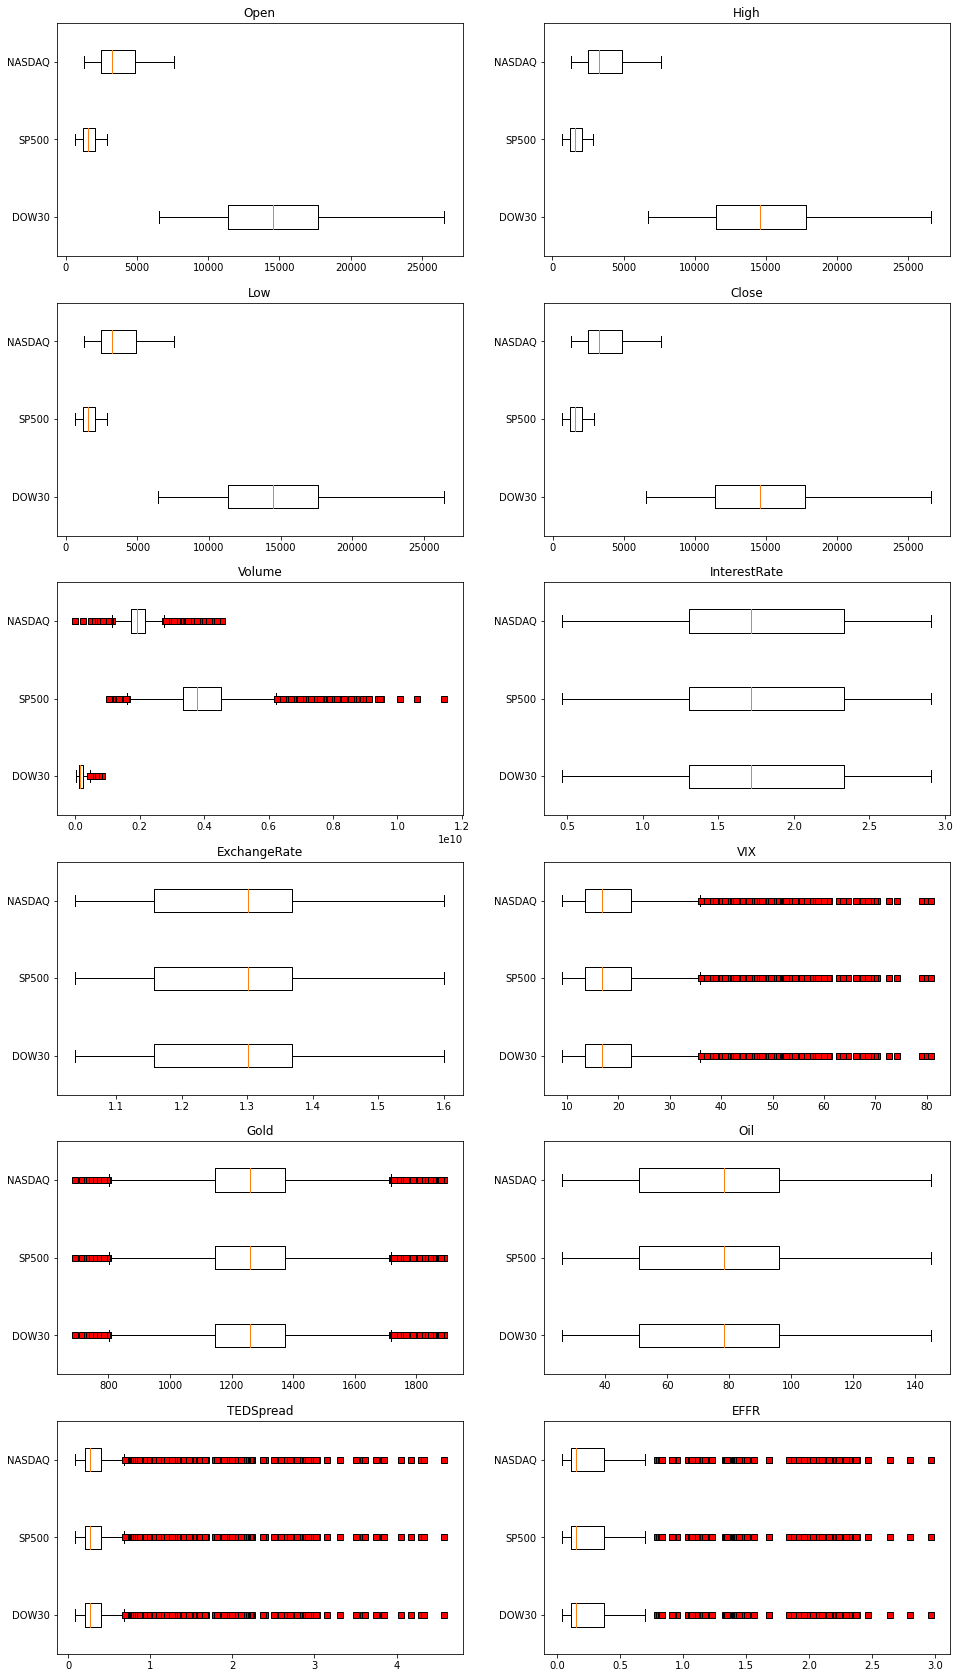

In [10]:
# compare attributes' distribution of value
def box_plot_all(datasets):
    baseline = next(iter(datasets.values()))
    fig, axs = plt.subplots(ceil(len(baseline.columns) / 2), 2, figsize=(16, len(baseline.columns) * 2.5))
    
    for i, column in enumerate(baseline.columns):
        box_plot(datasets, column, axs=axs[i // 2, i % 2])

box_plot_all(features)

We see outliers in the following attributes: Volume, VIX, Gold, TEDSpread, and EFFR.
We decide to keep the outliers in the datasets since they are all part of the natural fluctuation of the stock market. Removing the outliers wouldn't make sense because the data is dependent on each other and outliers happen frequently depending on what affects the stock market. This is why we decided to try various types of feature engineering in order to improve our results.

Based on the above boxplots, we can see that these three datasets, which represent three different stock market, have very different range of stock prices (Open, High, Low, Close) and trading volumns (Volume). Therefore, we cannot combine them into a single dataset and treat it as one market to make prediction on.


# Feature Engineering

In [11]:
add_engineered_features = []

In [12]:
# moving average
def macd(data, period1=12, period2=26):
    df = data.copy()
    df['p1'] = df['Open'].rolling(period1).mean()
    df['p2'] = df['Open'].rolling(period2).mean()
    data['MACD'] = df['p1'] - df['p2']
    return data

add_engineered_features.append(macd)

In [13]:
# aroon oscillator
def aroon(data, period=25):
    df = data.copy()
    df['up'] = 100 * df.High.rolling(period + 1).apply(lambda x: x.argmax()) / period
    df['dn'] = 100 * df.Low.rolling(period + 1).apply(lambda x: x.argmin()) / period
    data['Aroon'] = df['up'] - df['dn']
    return data

add_engineered_features.append(aroon)

In [14]:
# accumulation/distribution
def ad(data, period=1):
    df = data.copy()
    df['MFM'] = df['Volume'] * (((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']))
    data['Accumulation/Distribution'] = df['MFM'].rolling(period).sum()
    return data 

add_engineered_features.append(ad)

In [15]:
#stochastic oscillator
def stochastic(data, period=14, ma=3):
    df = data.copy()
    df['14-high'] = df['High'].rolling(period).max()
    df['14-low'] = df['Low'].rolling(period).min()
    df['%K'] = 100 * (df['Close'] - df['14-low']) / (df['14-high'] - df['14-low'])
    data['Stochastic Oscillator'] = df['%K'].rolling(ma).mean()
    return data

add_engineered_features.append(stochastic)

In [16]:
engineered_features = {}
for name, dataset_features in features.items():
    engineered_features[name] = dataset_features
    for add_engineered_feature in add_engineered_features:
        engineered_features[name] = add_engineered_feature(engineered_features[name])
    engineered_features[name] = engineered_features[name].iloc[26:]
    original_features = [feature.value for feature in Features if feature not in (Features.DATE, Features.LABEL)]
    engineered_features[name] = engineered_features[name].drop(original_features, axis=1)

In [17]:
show_preview(engineered_features)

DOW30 dataset preview:


,MACD,Aroon,Accumulation/Distribution,Stochastic Oscillator
26,162.813277,52.0,4.910995e+07,58.968970
27,157.746119,52.0,-1.042478e+08,36.781803
28,154.380584,52.0,1.306839e+08,37.469111
29,153.867163,52.0,-1.711096e+07,31.671928
30,143.754608,52.0,-2.647650e+07,40.425594




SP500 dataset preview:


,MACD,Aroon,Accumulation/Distribution,Stochastic Oscillator
26,18.066229,52.0,1.069153e+09,67.377408
27,17.812827,52.0,-7.989264e+08,47.402635
28,17.817567,52.0,3.189416e+09,50.688135
29,18.478720,52.0,1.408910e+09,53.519700
30,18.730321,52.0,-2.331776e+09,66.151824




NASDAQ dataset preview:


,MACD,Aroon,Accumulation/Distribution,Stochastic Oscillator
26,46.988842,52.0,2.635712e+08,73.754699
27,47.282485,52.0,4.347054e+08,63.594268
28,48.427935,52.0,1.629753e+09,72.801411
29,50.551971,52.0,1.456576e+09,83.264608
30,52.615059,80.0,-1.747703e+09,88.960716


In [18]:
show_statistics(engineered_features)

DOW30 dataset statistics:


,MACD,Aroon,Accumulation/Distribution,Stochastic Oscillator
count,2422.000000,2422.000000,2.422000e+03,2422.000000
mean,35.179797,21.550784,1.667395e+07,62.054203
std,202.245020,63.562266,1.427795e+08,29.161424
min,-958.554099,-100.000000,-6.434945e+08,1.092439
25%,-65.684254,-44.000000,-6.112155e+07,36.955610
50%,59.154569,44.000000,2.432622e+07,68.825778
75%,154.529084,76.000000,9.712175e+07,88.858251
max,620.809558,100.000000,7.767108e+08,99.957062




SP500 dataset statistics:


,MACD,Aroon,Accumulation/Distribution,Stochastic Oscillator
count,2422.000000,2422.000000,2.422000e+03,2422.000000
mean,3.928846,24.175062,4.743658e+08,62.838855
std,22.364211,62.211979,2.828041e+09,28.672545
min,-116.360967,-100.000000,-9.255214e+09,0.866648
25%,-7.632062,-40.000000,-1.661426e+09,37.402694
50%,7.533558,48.000000,8.233031e+08,70.432774
75%,17.858281,76.000000,2.758236e+09,89.026447
max,59.443381,100.000000,9.126673e+09,99.928361




NASDAQ dataset statistics:


,MACD,Aroon,Accumulation/Distribution,Stochastic Oscillator
count,2422.000000,2422.000000,2.422000e+03,2422.000000
mean,14.513927,24.949628,2.664129e+08,63.654931
std,56.765053,61.585092,1.346366e+09,29.016296
min,-222.106405,-100.000000,-3.987990e+09,0.745185
25%,-16.463717,-36.000000,-8.735426e+08,38.777039
50%,22.166087,48.000000,4.794158e+08,72.613680
75%,51.181290,76.000000,1.419445e+09,90.205862
max,179.147170,100.000000,3.746013e+09,99.966102


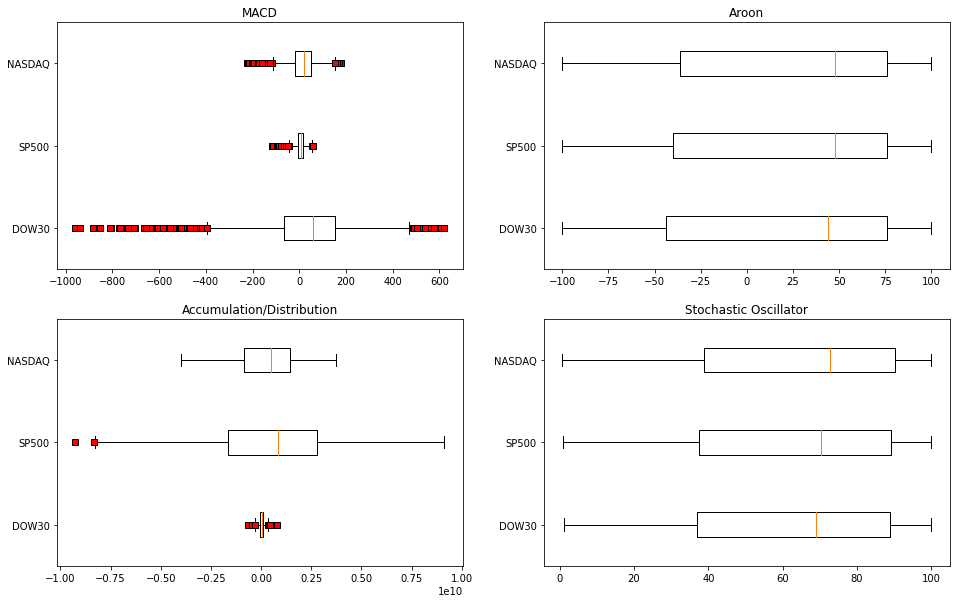

In [19]:
# compare attributes' distribution of value
box_plot_all(engineered_features)

# Models

In [20]:
trainers = {}

The SVM model performs 3 things:
    
    - Scales the data so that it is normalized to reduce runtime.
    - Performs dimensionality reduction using PCA to reduce runtime.
        - Tries to reduce our dataset to different dimensionalities (1-10) and find the best one
    - Runs SVM
        - Tries to train the model using different kernels ('linear', 'rbf', and 'poly') and find the best one
Using these steps, we can mitigate the time spent training the SVM model without severely impacting the accuracy.

In [21]:
# SVM
def SVM_trainer():
    """
    
    """
    scaler = StandardScaler()
    pca = PCA()
    svm = SVC()

    pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svm', svm)])

    param_grid = {
        'pca__n_components': list(range(1, 11)),
        'svm__kernel': ['linear', 'rbf', 'poly']
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    return grid_search

trainers["SVM"] = SVM_trainer

The KNN model performs 3 things:
    
    - Scales the data so that it is normalized to reduce runtime.
    - Performs dimensionality reduction using PCA to reduce runtime.
        - Tries to reduce our dataset to different dimensionalities (1-10) and find the best one
    - Runs KNN
        - Tries to train the model using different numbers of neighbors (1-25) and find the best one
    
Using these steps, we can mitigate the time spent training the SVM model without severely impacting the accuracy.

In [22]:
# KNN
def KNN_trainer():
    """
    
    """
    scaler = StandardScaler()
    pca = PCA()
    knn = KNeighborsClassifier(n_neighbors=7)
    pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('knn', knn)])

    param_grid = {
        'pca__n_components': list(range(1, 11)),
        'knn__n_neighbors': list(range(1, 26))
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    return grid_search

trainers["KNN"] = KNN_trainer

The Neural Network model performs 3 things:
    
    - Scales the data so that it is normalized to reduce runtime and to prevent some features from outweighing others.
    - Tests varying hidden layers in order to best determine which would have the greatest performance.
    - Runs Neural Networks.
        - Tests different activation functions ('logistic', 'tanh', and 'relu') to find the best one
Using these steps, we can mitigate the time spent training the Neural Network model without severely impacting the accuracy.

In [23]:
# Neural Network
def NN_trainer():
    """
    
    """
    scaler = StandardScaler()
    nn = MLPClassifier()

    pipeline = Pipeline(steps=[('scaler', scaler), ('nn', nn)])
    param_grid = {
        'nn__hidden_layer_sizes': list(range(30, 61, 10)),
        'nn__activation': ['logistic', 'tanh', 'relu']
    }
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    
    return grid_search

trainers["Neural Network"] = NN_trainer

In [24]:
def AB_Trainer():
    ab = AdaBoostClassifier(n_estimators=1000, learning_rate=0.0005)
    pipeline = Pipeline(steps=[('ab', ab)])
    
    param_grid = {
        'ab__n_estimators': list(range(500, 1001, 250)),
        'ab__learning_rate': [0.01, 0.001, 0.0001]
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy')
    return grid_search

trainers["Adaboosting"] = AB_Trainer

In [25]:
# Naive Bayes
def NB_Trainer():
    nb = GaussianNB()

    # Create a GridSearchCV to run the classification based on accuracy.
    grid_search = GridSearchCV(nb, {}, scoring='accuracy')
    
    return grid_search

trainers["Naive Bayes"] = NB_Trainer

The Ensemble model 
- combines our SVM model, KNN model and Neural Network model.
- uses the prediction from each of the three models as a vote, and it takes the majority vote as its final prediction.

In [26]:
# Ensemble must be the last classifier in the models list. 
# This is because it relies on all other models in order to be created.

# Ensemble
def ensemble_trainer(models):
    """
    
    """
    ensemble = VotingClassifier(estimators=list(models.items()), voting='hard')
    return ensemble
trainers["Ensemble"] = ensemble_trainer

In [27]:
@ignore_warnings(category=ConvergenceWarning)
def train_models(models, features, labels):
    results = {}
    for name, model in models.items():
        scores = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
        model_results = {}
        model_results["mean"] = scores.mean() * 100
        model_results["std"] = scores.std() * 100
        results[name] = model_results

        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (model_results["mean"], model_results["std"], name))
    return results

In [28]:
def get_models(trainers):
    models = {}
    for name, trainer in trainers.items():
        if name == "Ensemble":
            models[name] = trainer(models)
        else:
            models[name] = trainer()
    return models

# Feature Engineering Results

In [29]:
def test_feature_engineering(title, feature_engineering, datasets, trainers):

    fe_results = {}
    fe_features, fe_labels = feature_engineering(datasets)
    for name in datasets.keys():
        models = get_models(trainers)
        print(f"{title} results for {name}:")
        fe_results[name] = train_models(models, fe_features[name], fe_labels[name])
        print("")
    return fe_results

### We tried three different feature engineerings. 

## 1: Removed Date, TEDSpread, EFFR
* In the first one, we removed the date since we want to see whether we can get good prediction results assuming each day’s stock price is independent from the previous days. We also removed TEDSpread and EFFR features since initially we believe they are not quite related to the prediction of the stock price.

In [30]:
def feature_engineer_1(datasets):
    fe_features = {}
    fe_labels = {}
    for name, dataset in datasets.items():
        processed_dataset = dataset.drop(['Date', 'TEDSpread', 'EFFR'], axis=1)
        features = processed_dataset.drop([Features.LABEL], axis=1)
        labels = processed_dataset[Features.LABEL]
        fe_features[name] = features
        fe_labels[name] = labels
    return fe_features, fe_labels

### Results:
    Feature Engineering 1 results for DOW30:
    Accuracy: 54.25 (+/- 0.05) [SVM]
    Accuracy: 50.04 (+/- 3.25) [KNN]
    Accuracy: 52.37 (+/- 3.79) [Neural Network]
    Accuracy: 51.96 (+/- 3.08) [Adaboosting]
    Accuracy: 51.92 (+/- 4.79) [Naive Bayes]
    Accuracy: 51.96 (+/- 4.61) [Ensemble]

    Feature Engineering 1 results for SP500:
    Accuracy: 52.94 (+/- 3.57) [SVM]
    Accuracy: 49.71 (+/- 2.06) [KNN]
    Accuracy: 52.82 (+/- 3.81) [Neural Network]
    Accuracy: 53.02 (+/- 3.21) [Adaboosting]
    Accuracy: 54.58 (+/- 0.47) [Naive Bayes]
    Accuracy: 53.06 (+/- 3.32) [Ensemble]

    Feature Engineering 1 results for NASDAQ:
    Accuracy: 55.68 (+/- 0.04) [SVM]
    Accuracy: 47.26 (+/- 4.36) [KNN]
    Accuracy: 55.23 (+/- 0.83) [Neural Network]
    Accuracy: 52.94 (+/- 3.96) [Adaboosting]
    Accuracy: 55.64 (+/- 0.40) [Naive Bayes]
    Accuracy: 55.31 (+/- 0.49) [Ensemble]

In [31]:
fe_1_results = test_feature_engineering("Feature Engineering 1", feature_engineer_1, datasets, trainers)

Feature Engineering 1 results for DOW30:
Accuracy: 54.25 (+/- 0.05) [SVM]
Accuracy: 50.04 (+/- 3.25) [KNN]
Accuracy: 52.37 (+/- 3.79) [Neural Network]
Accuracy: 51.96 (+/- 3.08) [Adaboosting]
Accuracy: 51.92 (+/- 4.79) [Naive Bayes]
Accuracy: 51.96 (+/- 4.61) [Ensemble]

Feature Engineering 1 results for SP500:
Accuracy: 52.94 (+/- 3.57) [SVM]
Accuracy: 49.71 (+/- 2.06) [KNN]
Accuracy: 52.82 (+/- 3.81) [Neural Network]
Accuracy: 53.02 (+/- 3.21) [Adaboosting]
Accuracy: 54.58 (+/- 0.47) [Naive Bayes]
Accuracy: 53.06 (+/- 3.32) [Ensemble]

Feature Engineering 1 results for NASDAQ:
Accuracy: 55.68 (+/- 0.04) [SVM]
Accuracy: 47.26 (+/- 4.36) [KNN]
Accuracy: 55.23 (+/- 0.83) [Neural Network]
Accuracy: 52.94 (+/- 3.96) [Adaboosting]
Accuracy: 55.64 (+/- 0.40) [Naive Bayes]
Accuracy: 55.31 (+/- 0.49) [Ensemble]



## 2: Added Previous Day's Label | Removed Date, TEDSpread, EFFR
* In the second one, we added the predictions of the previous day of the other two datasets, and we removed the date, TEDSpred, and EFFR as we did in the first. Comparing the first and the second, we are able to conclude if adding the predictions of the previous day of the other two datasets would improve accuracy.

In [32]:
def feature_engineer_2(datasets):
    fe_features = {}
    fe_labels = {}
    prev_labels = {}
    dataset_labels = {}
    for name, dataset in datasets.items():
        dataset_labels[name] = dataset.iloc[:, 1]
    for name, dataset in datasets.items():
        processed_dataset = dataset.drop(['Date', 'TEDSpread', 'EFFR'], axis=1)
        features = processed_dataset
        for other_name, other_dataset_labels in dataset_labels.items():
            if name != other_name:
                features[other_name.value] = other_dataset_labels
                features[other_name.value] = features[other_name.value].shift(periods=1, fill_value=-1)
        features.drop(features.index[[0]], inplace=True)
        labels = features['LABEL']    
        features = features.drop(['LABEL'], axis=1)
        
        fe_features[name] = features
        fe_labels[name] = labels
    return fe_features, fe_labels
# fe_2_features, fe_2_labels = feature_engineer_2(datasets)
# for name, dataset in fe_2_features.items():
#     display(dataset)

    Feature Engineering 2 results for DOW30:
    Accuracy: 53.37 (+/- 1.33) [SVM]
    Accuracy: 51.08 (+/- 2.67) [KNN]
    Accuracy: 52.10 (+/- 4.08) [Neural Network]
    Accuracy: 51.94 (+/- 3.17) [Adaboosting]
    Accuracy: 52.02 (+/- 4.64) [Naive Bayes]
    Accuracy: 52.96 (+/- 2.28) [Ensemble]

    Feature Engineering 2 results for SP500:
    Accuracy: 54.76 (+/- 0.05) [SVM]
    Accuracy: 50.22 (+/- 2.26) [KNN]
    Accuracy: 54.39 (+/- 0.66) [Neural Network]
    Accuracy: 53.12 (+/- 3.25) [Adaboosting]
    Accuracy: 54.68 (+/- 0.41) [Naive Bayes]
    Accuracy: 54.19 (+/- 1.03) [Ensemble]

    Feature Engineering 2 results for NASDAQ:
    Accuracy: 54.64 (+/- 2.17) [SVM]
    Accuracy: 50.06 (+/- 4.12) [KNN]
    Accuracy: 55.62 (+/- 0.23) [Neural Network]
    Accuracy: 51.66 (+/- 3.96) [Adaboosting]
    Accuracy: 55.66 (+/- 0.40) [Naive Bayes]
    Accuracy: 54.92 (+/- 1.02) [Ensemble]

In [33]:
fe_2_results = test_feature_engineering("Feature Engineering 2", feature_engineer_2, datasets, trainers)

Feature Engineering 2 results for DOW30:
Accuracy: 53.37 (+/- 1.33) [SVM]
Accuracy: 51.08 (+/- 2.67) [KNN]
Accuracy: 52.10 (+/- 4.08) [Neural Network]
Accuracy: 51.94 (+/- 3.17) [Adaboosting]
Accuracy: 52.02 (+/- 4.64) [Naive Bayes]
Accuracy: 52.96 (+/- 2.28) [Ensemble]

Feature Engineering 2 results for SP500:
Accuracy: 54.76 (+/- 0.05) [SVM]
Accuracy: 50.22 (+/- 2.26) [KNN]
Accuracy: 54.39 (+/- 0.66) [Neural Network]
Accuracy: 53.12 (+/- 3.25) [Adaboosting]
Accuracy: 54.68 (+/- 0.41) [Naive Bayes]
Accuracy: 54.19 (+/- 1.03) [Ensemble]

Feature Engineering 2 results for NASDAQ:
Accuracy: 54.64 (+/- 2.17) [SVM]
Accuracy: 50.06 (+/- 4.12) [KNN]
Accuracy: 55.62 (+/- 0.23) [Neural Network]
Accuracy: 51.66 (+/- 3.96) [Adaboosting]
Accuracy: 55.66 (+/- 0.40) [Naive Bayes]
Accuracy: 54.92 (+/- 1.02) [Ensemble]



## 3: Added Previous Day's Label | Removed Date
* In the third one, we added the predictions of the previous day of the other two datasets, and we only removed the date. Comparing the second and third, we are able to conclude if adding TEDSpred, and EFFR features would improve accuracy.

In [34]:
def feature_engineer_3(datasets):
    fe_features = {}
    fe_labels = {}
    dataset_labels = {}
    for name, dataset in datasets.items():
        dataset_labels[name] = dataset.iloc[0:, 1]
    for name, dataset in datasets.items():
        processed_dataset = dataset.drop(['Date'], axis=1)
        features = processed_dataset
        for other_name, other_dataset_labels in dataset_labels.items():
            if name != other_name:
                features[other_name.value] = other_dataset_labels
                features[other_name.value] = features[other_name.value].shift(periods=1, fill_value=-1)
        features.drop(features.index[[0]], inplace=True)
        labels = features['LABEL']    
        features = features.drop(['LABEL'], axis=1)
        fe_features[name] = features
        fe_labels[name] = labels
    return fe_features, fe_labels
# fe_3_features, fe_3_labels = feature_engineer_3(datasets)
# for name, dataset in fe_3_features.items():
#     display(dataset)

    Feature Engineering 3 results for DOW30:
    Accuracy: 54.03 (+/- 0.53) [SVM]
    Accuracy: 49.94 (+/- 2.67) [KNN]
    Accuracy: 52.88 (+/- 3.92) [Neural Network]
    Accuracy: 52.02 (+/- 3.23) [Adaboosting]
    Accuracy: 52.02 (+/- 4.64) [Naive Bayes]
    Accuracy: 52.43 (+/- 3.78) [Ensemble]

    Feature Engineering 3 results for SP500:
    Accuracy: 54.76 (+/- 0.05) [SVM]
    Accuracy: 49.57 (+/- 1.65) [KNN]
    Accuracy: 52.72 (+/- 3.17) [Neural Network]
    Accuracy: 53.12 (+/- 3.25) [Adaboosting]
    Accuracy: 54.68 (+/- 0.41) [Naive Bayes]
    Accuracy: 53.53 (+/- 2.33) [Ensemble]

    Feature Engineering 3 results for NASDAQ:
    Accuracy: 54.68 (+/- 2.08) [SVM]
    Accuracy: 47.73 (+/- 4.64) [KNN]
    Accuracy: 55.58 (+/- 0.90) [Neural Network]
    Accuracy: 52.76 (+/- 4.04) [Adaboosting]
    Accuracy: 55.66 (+/- 0.40) [Naive Bayes]
    Accuracy: 54.92 (+/- 1.30) [Ensemble]

In [35]:
fe_3_results = test_feature_engineering("Feature Engineering 3", feature_engineer_3, datasets, trainers)

Feature Engineering 3 results for DOW30:
Accuracy: 54.03 (+/- 0.53) [SVM]
Accuracy: 49.94 (+/- 2.67) [KNN]
Accuracy: 52.88 (+/- 3.92) [Neural Network]
Accuracy: 52.02 (+/- 3.23) [Adaboosting]
Accuracy: 52.02 (+/- 4.64) [Naive Bayes]
Accuracy: 52.43 (+/- 3.78) [Ensemble]

Feature Engineering 3 results for SP500:
Accuracy: 54.76 (+/- 0.05) [SVM]
Accuracy: 49.57 (+/- 1.65) [KNN]
Accuracy: 52.72 (+/- 3.17) [Neural Network]
Accuracy: 53.12 (+/- 3.25) [Adaboosting]
Accuracy: 54.68 (+/- 0.41) [Naive Bayes]
Accuracy: 53.53 (+/- 2.33) [Ensemble]

Feature Engineering 3 results for NASDAQ:
Accuracy: 54.68 (+/- 2.08) [SVM]
Accuracy: 47.73 (+/- 4.64) [KNN]
Accuracy: 55.58 (+/- 0.90) [Neural Network]
Accuracy: 52.76 (+/- 4.04) [Adaboosting]
Accuracy: 55.66 (+/- 0.40) [Naive Bayes]
Accuracy: 54.92 (+/- 1.30) [Ensemble]



## 4: Added Previous Day's Label, Aroon, Stochastic Oscillator | Removed Date, Volume, VIX, Gold, TEDSpread, and EFFR
* In the third one, we added the predictions of the previous day of the other two datasets, and we only removed the date. Comparing the second and third, we are able to conclude if adding TEDSpred, and EFFR features would improve accuracy.

In [36]:
def feature_engineer_4(datasets):
    fe_features = {}
    fe_labels = {}
    dataset_labels = {}
    fe_engineered_features = [aroon, stochastic]
    for name, dataset in datasets.items():
        dataset_labels[name] = dataset.iloc[0:, 1]
    
    for name, dataset in datasets.items():
        processed_dataset = dataset.drop(['Date', 'Volume', 'VIX', 'Gold', 'TEDSpread', 'EFFR'], axis=1)
        for fe_engineered_feature in fe_engineered_features:
            processed_dataset = add_engineered_feature(processed_dataset)
        features = processed_dataset
        for other_name, other_dataset_labels in dataset_labels.items():
            if name != other_name:
                features[other_name.value] = other_dataset_labels
                features[other_name.value] = features[other_name.value].shift(periods=1, fill_value=-1)
        features.drop(features.index[range(26)], inplace=True)
        labels = features['LABEL']    
        features = features.drop(['LABEL'], axis=1)
        fe_features[name] = features
        fe_labels[name] = labels
    return fe_features, fe_labels
# fe_4_features, fe_4_labels = feature_engineer_4(datasets)
# for name, dataset in fe_4_features.items():
#     display(dataset)

    Feature Engineering 4 results for DOW30:
    Accuracy: 54.38 (+/- 0.19) [SVM]
    Accuracy: 52.35 (+/- 2.95) [KNN]
    Accuracy: 53.84 (+/- 0.90) [Neural Network]
    Accuracy: 53.38 (+/- 1.33) [Adaboosting]
    Accuracy: 52.15 (+/- 2.04) [Naive Bayes]
    Accuracy: 53.55 (+/- 1.22) [Ensemble]

    Feature Engineering 4 results for SP500:
    Accuracy: 54.75 (+/- 0.07) [SVM]
    Accuracy: 48.18 (+/- 2.76) [KNN]
    Accuracy: 54.25 (+/- 0.99) [Neural Network]
    Accuracy: 53.10 (+/- 3.30) [Adaboosting]
    Accuracy: 52.68 (+/- 3.73) [Naive Bayes]
    Accuracy: 52.89 (+/- 3.72) [Ensemble]

    Feature Engineering 4 results for NASDAQ:
    Accuracy: 55.74 (+/- 0.06) [SVM]
    Accuracy: 49.54 (+/- 2.73) [KNN]
    Accuracy: 55.74 (+/- 0.06) [Neural Network]
    Accuracy: 52.27 (+/- 5.58) [Adaboosting]
    Accuracy: 52.64 (+/- 4.84) [Naive Bayes]
    Accuracy: 53.55 (+/- 4.36) [Ensemble]

In [37]:
fe_4_results = test_feature_engineering("Feature Engineering 4", feature_engineer_4, datasets, trainers)

Feature Engineering 4 results for DOW30:
Accuracy: 54.38 (+/- 0.19) [SVM]
Accuracy: 52.35 (+/- 2.95) [KNN]
Accuracy: 53.84 (+/- 0.90) [Neural Network]
Accuracy: 53.38 (+/- 1.33) [Adaboosting]
Accuracy: 52.15 (+/- 2.04) [Naive Bayes]
Accuracy: 53.55 (+/- 1.22) [Ensemble]

Feature Engineering 4 results for SP500:
Accuracy: 54.75 (+/- 0.07) [SVM]
Accuracy: 48.18 (+/- 2.76) [KNN]
Accuracy: 54.25 (+/- 0.99) [Neural Network]
Accuracy: 53.10 (+/- 3.30) [Adaboosting]
Accuracy: 52.68 (+/- 3.73) [Naive Bayes]
Accuracy: 52.89 (+/- 3.72) [Ensemble]

Feature Engineering 4 results for NASDAQ:
Accuracy: 55.74 (+/- 0.06) [SVM]
Accuracy: 49.54 (+/- 2.73) [KNN]
Accuracy: 55.74 (+/- 0.06) [Neural Network]
Accuracy: 52.27 (+/- 5.58) [Adaboosting]
Accuracy: 52.64 (+/- 4.84) [Naive Bayes]
Accuracy: 53.55 (+/- 4.36) [Ensemble]



## 5: Added Previous Day's Label, MACD, Accumulation/Distribution, Aroon, Stochastic Oscillator | Removed Date
* In the third one, we added the predictions of the previous day of the other two datasets, and we only removed the date. Comparing the second and third, we are able to conclude if adding TEDSpred, and EFFR features would improve accuracy.

In [38]:
def feature_engineer_5(datasets):
    fe_features = {}
    fe_labels = {}
    dataset_labels = {}
    fe_engineered_features = [macd, aroon, ad, stochastic]
    for name, dataset in datasets.items():
        dataset_labels[name] = dataset.iloc[0:, 1]
    for name, dataset in datasets.items():
        processed_dataset = dataset.drop(['Date'], axis=1)
        for fe_engineered_feature in fe_engineered_features:
            processed_dataset = add_engineered_feature(processed_dataset)
        features = processed_dataset
        for other_name, other_dataset_labels in dataset_labels.items():
            if name != other_name:
                features[other_name.value] = other_dataset_labels
                features[other_name.value] = features[other_name.value].shift(periods=1, fill_value=-1)
        features.drop(features.index[range(26)], inplace=True)
        labels = features['LABEL']    
        features = features.drop(['LABEL'], axis=1)
        fe_features[name] = features
        fe_labels[name] = labels
    return fe_features, fe_labels
# fe_5_features, fe_5_labels = feature_engineer_5(datasets)
# for name, dataset in fe_5_features.items():
#     display(dataset)

    Feature Engineering 5 results for DOW30:
    Accuracy: 53.72 (+/- 1.14) [SVM]
    Accuracy: 50.70 (+/- 2.90) [KNN]
    Accuracy: 53.67 (+/- 2.63) [Neural Network]
    Accuracy: 53.72 (+/- 1.47) [Adaboosting]
    Accuracy: 52.10 (+/- 4.46) [Naive Bayes]
    Accuracy: 52.77 (+/- 2.73) [Ensemble]

    Feature Engineering 5 results for SP500:
    Accuracy: 53.01 (+/- 3.47) [SVM]
    Accuracy: 51.36 (+/- 2.39) [KNN]
    Accuracy: 52.89 (+/- 3.22) [Neural Network]
    Accuracy: 53.10 (+/- 3.30) [Adaboosting]
    Accuracy: 54.83 (+/- 0.12) [Naive Bayes]
    Accuracy: 53.01 (+/- 3.47) [Ensemble]

    Feature Engineering 5 results for NASDAQ:
    Accuracy: 55.74 (+/- 0.06) [SVM]
    Accuracy: 51.69 (+/- 3.74) [KNN]
    Accuracy: 55.08 (+/- 1.41) [Neural Network]
    Accuracy: 52.85 (+/- 5.76) [Adaboosting]
    Accuracy: 55.33 (+/- 1.28) [Naive Bayes]
    Accuracy: 54.71 (+/- 1.65) [Ensemble]

In [39]:
fe_5_results = test_feature_engineering("Feature Engineering 5", feature_engineer_5, datasets, trainers)

Feature Engineering 5 results for DOW30:
Accuracy: 53.72 (+/- 1.14) [SVM]
Accuracy: 50.70 (+/- 2.90) [KNN]
Accuracy: 53.67 (+/- 2.63) [Neural Network]
Accuracy: 53.72 (+/- 1.47) [Adaboosting]
Accuracy: 52.10 (+/- 4.46) [Naive Bayes]
Accuracy: 52.77 (+/- 2.73) [Ensemble]

Feature Engineering 5 results for SP500:
Accuracy: 53.01 (+/- 3.47) [SVM]
Accuracy: 51.36 (+/- 2.39) [KNN]
Accuracy: 52.89 (+/- 3.22) [Neural Network]
Accuracy: 53.10 (+/- 3.30) [Adaboosting]
Accuracy: 54.83 (+/- 0.12) [Naive Bayes]
Accuracy: 53.01 (+/- 3.47) [Ensemble]

Feature Engineering 5 results for NASDAQ:
Accuracy: 55.74 (+/- 0.06) [SVM]
Accuracy: 51.69 (+/- 3.74) [KNN]
Accuracy: 55.08 (+/- 1.41) [Neural Network]
Accuracy: 52.85 (+/- 5.76) [Adaboosting]
Accuracy: 55.33 (+/- 1.28) [Naive Bayes]
Accuracy: 54.71 (+/- 1.65) [Ensemble]



# Results Analysis

### Compare results on each dataset

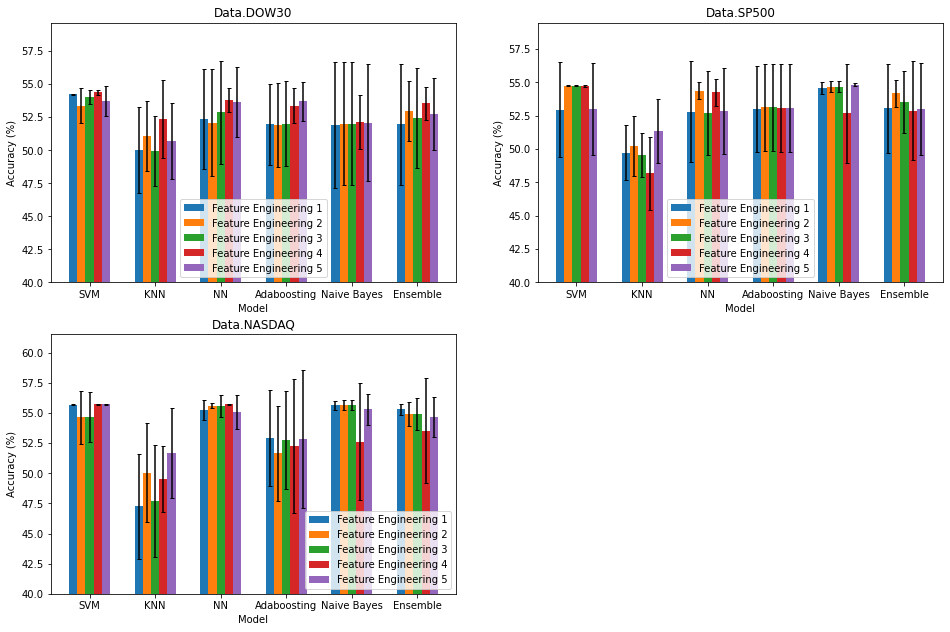

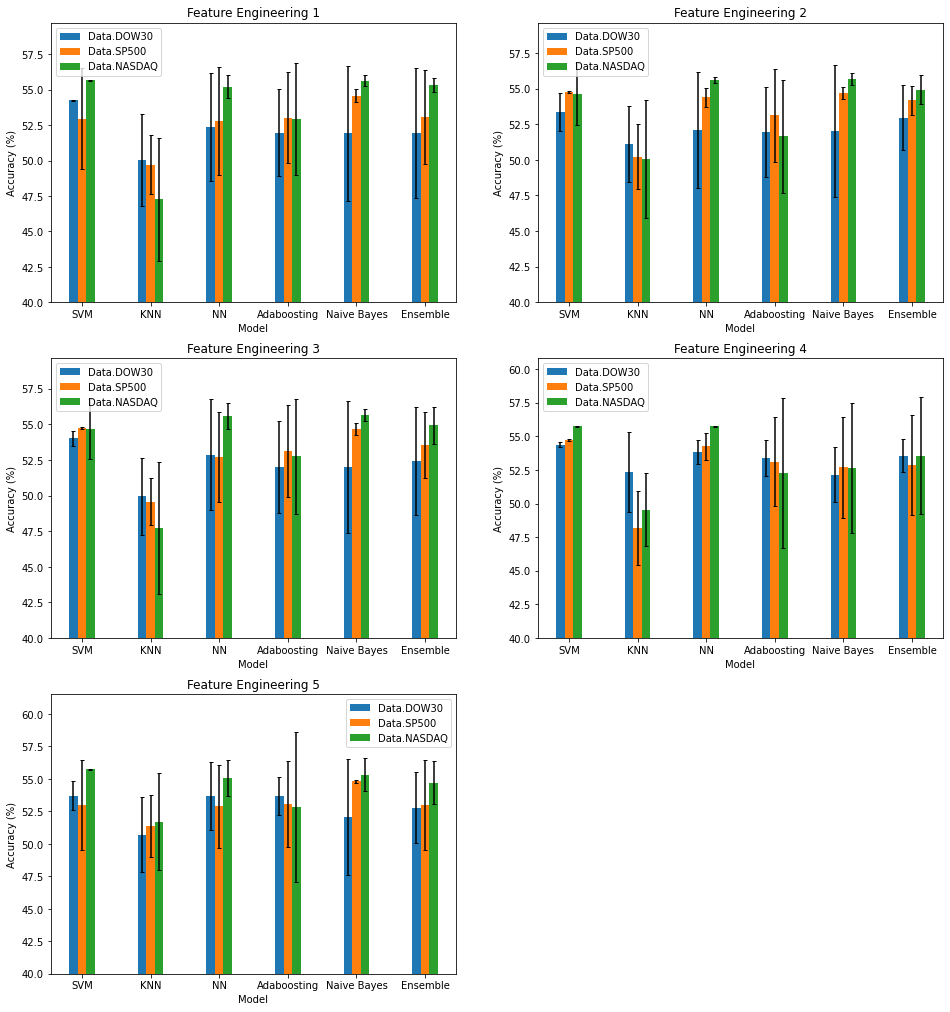

In [110]:
 # set width of bar
results = {"Feature Engineering 1": fe_1_results, 
           "Feature Engineering 2": fe_2_results,
           "Feature Engineering 3": fe_3_results, 
           "Feature Engineering 4": fe_4_results, 
           "Feature Engineering 5": fe_5_results
          }
# print(results)
x_labels = ['SVM', 'KNN', 'NN', 'Adaboosting', 'Naive Bayes', 'Ensemble']
def bar_plot_feature_comparison(fe_results, bar_width=0.125):
    all_formatted_results = {}
    fe_baseline = next(iter(fe_results.values()))
    index_baseline = next(iter(fe_baseline.values()))
    for model_name, model in fe_baseline.items():
        bar_positions = np.arange(len(model))
        all_formatted_results[model_name] = {}
        for fe_name, _ in fe_results.items():
            all_formatted_results[model_name][fe_name] = {
                "means": [], 
                "stds": [], 
                "positions": bar_positions,
                "models": model.keys()
            }
            bar_positions = [x + bar_width for x in bar_positions]
    
    # 3 graphs for DOW30, SP500, NASDAQ, each one plots each feature engineering for each model
    for fe_name, fe in fe_results.items():
        for index_name, index in fe.items():
            for model in index.values():
                all_formatted_results[index_name][fe_name]["means"].append(model["mean"])
                all_formatted_results[index_name][fe_name]["stds"].append(model["std"])

    fig, axs = plt.subplots(ceil(len(all_formatted_results) / 2), 2, figsize=(16, len(all_formatted_results) * 3.5))
    i = 0
    for fe_name, fe_formatted_results in all_formatted_results.items():
        ax = axs[i // 2, i % 2]
        for name, result in fe_formatted_results.items():
            ax.bar(result["positions"], result["means"], width = bar_width,
                   label=name, yerr=result["stds"], capsize=2)
            
        ax.set_ylim(ymin=40)
        plt.sca(ax)
        plt.xlabel('Model')
        plt.ylabel('Accuracy (%)')
        
        plt.xticks([(r + bar_positions[r] - bar_width) / 2 for r in range(len(bar_positions))], x_labels)
        plt.title(fe_name)
        plt.legend()
        i += 1
    while i < ceil(len(all_formatted_results) / 2) * 2:
        axs[i // 2, i % 2].set_axis_off()
        i += 1
    plt.show()
                
                
def bar_plot_index_comparison(fe_results):
    pass

def bar_plot_model_comparison(fe_results, bar_width=0.125):
    all_formatted_results = {}
    assert(len(fe_results))
    fe_baseline = next(iter(fe_results.values()))
    index_baseline = next(iter(fe_baseline.values()))
    
    for fe_name, fe in fe_results.items():
        bar_positions = np.arange(len(index_baseline))
        fe_formatted_results = {}
        for index_name, index in fe.items():
            model_means, model_stds, model_names = [], [], []
            for model in index.values():
                model_means.append(model["mean"])
                model_stds.append(model["std"])
            fe_formatted_results[index_name] = {
                "means": model_means, 
                "stds": model_stds, 
                "positions": bar_positions,
                "models": index.keys()
            }
            bar_positions = [x + bar_width for x in bar_positions]
        all_formatted_results[fe_name] = fe_formatted_results

    fig, axs = plt.subplots(ceil(len(all_formatted_results) / 2), 2, figsize=(16, len(all_formatted_results) * 3.5))
    i = 0
    for fe_name, fe_formatted_results in all_formatted_results.items():
        ax = axs[i // 2, i % 2]
        for name, result in fe_formatted_results.items():
            ax.bar(result["positions"], result["means"], width = bar_width,
                   label=name, yerr=result["stds"], capsize=2)
            
        ax.set_ylim(ymin=40)
        plt.sca(ax)
        plt.xlabel('Model')
        plt.ylabel('Accuracy (%)')
        
        plt.xticks([(r + bar_positions[r] - bar_width) / 2 for r in range(len(bar_positions))], x_labels)
        plt.title(fe_name)
        plt.legend()
        i += 1
    while i < ceil(len(all_formatted_results) / 2) * 2:
        axs[i // 2, i % 2].set_axis_off()
        i += 1
    plt.show()
        
                    
                    
print("")
bar_plot_feature_comparison(results)
bar_plot_model_comparison(results)
    
def bar_plot(data_1, data_2, data_3, err_1, err_2, err_3, title):
    barWidth = 0.1
    fig = plt.subplots(figsize =(12, 8))

    # Set position of bar on X axis
    br1 = np.arange(len(data_1))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    # Make the plot
    plt.bar(br1, data_1, color ='r', width = barWidth,
            edgecolor ='grey', label='DOW30', yerr=err_1, capsize=3)
    plt.bar(br2, data_2, color ='g', width = barWidth,
            edgecolor ='grey', label='SP500', yerr=err_2, capsize=3)
    plt.bar(br3, data_3, color ='b', width = barWidth,
            edgecolor ='grey', label='NASDAQ', yerr=err_3, capsize=3)

    # Adding Xticks
    plt.xlabel('Model', fontweight ='bold', fontsize = 15)
    plt.ylabel('Accuracy (%)', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(4)],
            ['SVM', 'KNN', 'NN', 'Ensemble'])
    plt.title(title)

    plt.legend()
    plt.show()
    
dow30_fe_1 = [54, 50, 52, 53]
dow30_error_fe_1 = [0, 3, 4, 3]
sp500_fe_1 = [53, 50, 53, 51]
sp500_error_fe_1 = [4, 2, 3, 4]
nasdaq_fe_1 = [56, 47, 56, 55]
nasdaq_error_fe_1 = [0, 4, 0, 0]
# bar_plot(dow30_fe_1, sp500_fe_1, nasdaq_fe_1, dow30_error_fe_1, sp500_error_fe_1, nasdaq_error_fe_1, "Feature Engineering 1")
    
dow30_fe_2 = [53, 51, 52, 53]
dow30_error_fe_2 = [1, 3, 3, 2]
sp500_fe_2 = [55, 50, 54, 54]
sp500_error_fe_2 = [0, 2, 1, 1]
nasdaq_fe_2 = [55, 50, 56, 54]
nasdaq_error_fe_2 = [2, 4, 0, 2]
# bar_plot(dow30_fe_2, sp500_fe_2, nasdaq_fe_2, dow30_error_fe_2, sp500_error_fe_2, nasdaq_error_fe_2, "Feature Engineering 2")
    
dow30_fe_3 = [54, 50, 53, 53]
dow30_error_fe_3 = [1, 3, 3, 2]
sp500_fe_3 = [55, 50, 53, 53]
sp500_error_fe_3 = [0, 2, 3, 2]
nasdaq_fe_3 = [55, 48, 55, 54]
nasdaq_error_fe_3 = [2, 5, 1, 2]
# bar_plot(dow30_fe_3, sp500_fe_3, nasdaq_fe_3, dow30_error_fe_3, sp500_error_fe_3, nasdaq_error_fe_3, "Feature Engineering 3")



To improve our results, we tried different feature engineerings and different models. For each model, we tried to find the best hyperparameters. Although the final models don’t have a perfect performance, they have already been improved from the original models with accuracies of ~49%.


Among the final models:
- For DOW30, feature engineering 3 performs the best. Among all methods, SVM generates the best accuracy, 54%.
- For SP500, feature engineering 2 performs the best. Among all methods, SVM generates the best accuracy, 55%.
- For NASDAQ, feature engineering 1 performs the best. Among all methods, SVM and Neural Network both generate the best accuracies, 56%.


Overall, SVM performs the best and KNN performs the worst.
The model didn’t work very well with our datasets in general. Since stock market price is influenced by a complex set of factors, we may need more data, more features and feature engineerings based on professional knowlegde to build better models.